# Blocking API Proposal

In this notebook, we demonstrate the (expected) use of blocking in anonlink-entity-servce. Suppose we have two data party - Alice and Bob. The steps of record linkage with blocking is as follows:

1. For each data party, generate candidate blocks / reversed index locally
2. For each data party, encode dataset with clkhash
3. For each data party, upload candidate blocks and encoded dataset to anonlink-client
4. Anonlink-client generates final blocks with candidate blocks uploaded from data parties and report block statistics
5. Anonlink-client sends blocks and data to anonlink-entity-service for matching
6. Anonlink-client sends results back to each data provider

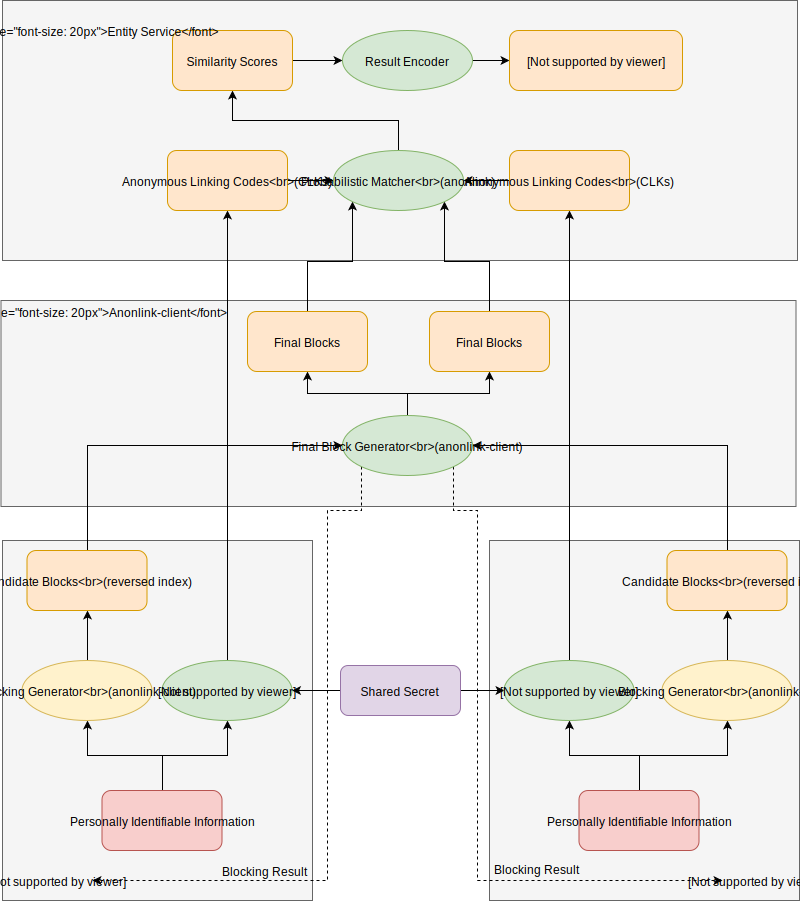

In [1]:
from IPython.core.display import SVG
SVG(filename='blocking_api.svg')

In [2]:
import os
import json
import pandas as pd
from clkhash.schema import from_json_dict

## Party A - Alice

Alice has a dataset in `data/2Parties/` called `PII_a_10000.csv`. To use anonlink entity service, she needs to do the following locally first:

1. Use encoder (`clkhash`) to compute CLKs for her entities data. Later the CLKs are then uploaded to the service
2. Use blocking generator (`anonlink-client`) to generate candidate blocks (aka reversed index). Later the reversed index are uploaded to service as well

### Step1 - Load dataset

In [3]:
df1 = pd.read_csv('data/2Parties/PII_a_10000.csv', skipinitialspace=True)
df1.head()

,entity_id,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,age,phone_number,soc_sec_id,blocking_number
0,16976,herman,calnin,34,irvine street,NaN,harrington,4054,qld,19160709,28,07 33961038,1592050,1
1,13309,jody,dennes,7561,marconi crescent,NaN,toowoomba,5086,nsw,19961223,34,02 20085279,3838941,0
2,10125,nicolas,mahony,86,yarra street,rosemount,upwey,6112,qld,19790705,27,02 38179391,1608786,6
3,2495,monica,jeffries,397,florentine circuit,NaN,batemans bay,2203,nsw,19820626,25,03 84076241,7616799,8
4,16931,zona,dichiera,3,chippindall circuit,NaN,milperra,5290,vic,19090308,27,08 00050600,8446162,0


Process data

In [4]:
df1 = df1.set_index('entity_id', drop=False).fillna('')
data1 = df1.to_dict(orient='split')['data']
print("Example PII", data1[0])

Example PII [16976, 'herman', 'calnin', 34, 'irvine street', '', 'harrington', 4054, 'qld', 19160709, 28, '07 33961038', 1592050, 1]


### Step2 - Generate Candidate Blocks

`anonlink-client` is the service to generate candidate blocks (aka reversed index). Later the reversed index are uploaded to service as well.

Note that a schema file is required to config the blocking where different blocking methods have different specific configuration.

In [5]:
blocking_config = {
    'signature': {
        "type": "p-sig",
        "version": 1,
        "output": {
            "type": "reverse_index",
        },
        "config": {
            # "blocking_features": ["given_name", "surname", "address_1", "address_2"],
            "blocking_features": [1, 2, 4, 5],
            "filter": {
                "type": "ratio",
                "max_occur_ratio": 0.02,
                "min_occur_ratio": 0.001,
            },
            "blocking-filter": {
                "type": "bloom filter",
                "number_hash_functions": 4,
                "bf_len": 4096,
            },
            "map_to_block_algorithm": {
                "type": "signature-based-blocks",
            },
            "signatureSpecs": [
                [
                    {"type": "characters_at", "config": {"pos": [0, 3, "7:9", "12:"]}, "feature_idx": 3},
                    {"type": "feature-value", "feature_idx": 5}
                ],
                [
                    {"type": "characters_at", "config": {"pos": [0]}, "feature_idx": 1},
                    {"type": "characters_at", "config": {"pos": [0]}, "feature_idx": 2},
                    {"type": "feature-value", "feature_idx": 5}
                ],
                [
                    {"type": "feature-value", "feature_idx": 2},
                ],
[
                    {"type": "characters_at", "config": {"pos": ["3:"]}, "feature_idx": 9},
                ],
                [
                    {"type": "metaphone", "feature_idx": 1},
                ],
                [
                    {"type": "metaphone", "feature_idx": 2},
                ],
                [
                    {"type": "metaphone", "feature_idx": 3},
                    {"type": "metaphone", "feature_idx": 4}
                ],
                [
                    {"type": "feature-value", "feature_idx": 10},
                ],
                [
                    {"type": "characters_at", "config": {"pos": ["0:3"]}, "feature_idx": 1},
                    {"type": "characters_at", "config": {"pos": ["0:3"]}, "feature_idx": 2},
                ],
            ],
        }
    },
    'candidate-blocking-filter': {
        'type': 'dummy'
    },
    'reverse-index': {
        'type': 'signature-based-blocks'
    }
}


In [6]:
from poc.blocks_generator import generate_candidate_blocks

block_obj_dp1 = generate_candidate_blocks(blocking_config, data1)

Number of Blocks:   1080
Minimum Block Size: 11
Maximum Block Size: 198
Average Block Size: 30
Median Block Size:  20


By checking statistics of blocking result, Alice and Bob can decide if they want to use this blocking config to proceed. Note that the blocking_config must be agreed by all data parties.

### Step3 - Generate CLKs

Once Alice and Bob are happy with the blocking result and decide to proceed, Alice can generate CLKs of data.

In [7]:
from poc.clk_util import generate_clks

# encoding
schema_json_fp = os.path.join('data', 'schema.json')
with open(schema_json_fp, "r") as read_file:
    schema_json = json.load(read_file)
schema = from_json_dict(schema_json)
encodings_dp1 = generate_clks(df1, schema=schema, secret_keys=("tick", "tock"))

generating CLKs: 100%|██████████| 10.0k/10.0k [00:02<00:00, 3.37kclk/s, mean=660, std=31.2]


## Party B - Bob

Now repeat the above 3 steps at Bob's side to get `block_obj_dp2` and `encoding_dp2`

In [8]:
# load data
df2 = pd.read_csv('data/2Parties/PII_b_10000.csv', skipinitialspace=True)
df2 = df2.set_index('entity_id', drop=False).fillna('')
data2 = df2.to_dict(orient='split')['data']
print("Example PII", data2[0])

# generate candidate blocks
block_obj_dp2 = generate_candidate_blocks(blocking_config, data2)

# encode data2
encodings_dp2 = generate_clks(df2, schema=schema, secret_keys=("tick", "tock"))

Example PII [4692, 'deborah', 'croll', 309, 'pandanus street', 'palm garden villas', 'dullwich hill', 4601, 'vic', 19650927, 29, '08 28856214', 9172697, 2]


generating CLKs:   0%|          | 0.00/10.0k [00:00<?, ?clk/s, mean=0, std=0]

Number of Blocks:   1049
Minimum Block Size: 11
Maximum Block Size: 195
Average Block Size: 29
Median Block Size:  19


generating CLKs: 100%|██████████| 10.0k/10.0k [00:02<00:00, 3.54kclk/s, mean=659, std=31.9]


## Anonlink-client

Now both blocking result and encoded data are uploaded to `anonlink-client`. It can perform final blocks generation and call `anonlink` to solve the problem with help of blocking.

### Step1 - Generate final blocks

Note: Please don't re-run the following cell

In [9]:
from poc.blocks_generator import generate_final_blocks
dp1_blocks, dp2_blocks = generate_final_blocks(blocking_config, block_obj_dp1, block_obj_dp2)

Block filter: [False False False ...  True False  True]


### Step2 - Call Anonlink solver to perform matching

In [10]:
from poc.server import solve
from poc.data_util import load_truth

solution = solve((encodings_dp1, encodings_dp2), (dp1_blocks, dp2_blocks), threshold=0.85)
print('Found {} matches'.format(len(solution)))
found_matches = set((a, b) for ((_, a), (_, b)) in solution)

the_truth = load_truth(df1, df2, id_col='entity_id')

tp = len(found_matches & the_truth)
fp = len(found_matches - the_truth)
fn = len(the_truth - found_matches)

precision = tp / (tp + fp)
recall = tp / (tp + fn)
print(f'precision: {precision}, recall: {recall}')


Found 4519 matches
precision: 0.9984509847311352, recall: 0.8961271102284012
